# Pre-Analysis Stage

This notebook executes the pre-analysis workflow for detector datasets using trigger 2.
<br>
The process involves:
- Loading of pre-processed detector data (output from the _Sophronia_ city stage, herein termed _reco_ data).
- Data cleaning to mitigate artifacts or anomalies arising from the NEXT reconstruction process.
- Application of selection criteria to the _Dorothea_ table to differentiate and isolate alpha ($\alpha$) and electron ($e$) populations.
- Generation of dataframes organized by analysis stage (hit and event-level), particle type ($\alpha$ and $e$), and pertinent detector sub-volumes.
- Storage of the processed and categorized information into a single output file per run for subsequent analysis phases.

In [2]:
import sys
sys.path.append('/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/libs')

import crudo
import fit_functions as ff
from   iminuit import Minuit
from   iminuit.cost import LeastSquares
from   invisible_cities.reco.corrections import read_maps
from   invisible_cities.reco.corrections import apply_all_correction
from   invisible_cities.types.symbols    import NormStrategy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import plotting_tools as pt
import tables as tb
from   scipy import integrate
from   scipy.optimize import curve_fit
from   scipy.stats    import linregress

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Run Information

In [3]:
# List of high-energy (HE) runs
runs_info = {
                # # Condition 0:  castle = open #
                # 15062: {"duration": 84783, "OK": 69564, "LOST": 133911, "condition": 0},
                # 15063: {"duration": 79120, "OK": 65052, "LOST": 124131, "condition": 0},
                # 15076: {"duration": 69316, "OK": 56775, "LOST": 108095, "condition": 0},
                # # Condition 1:  castle = pclosed & RAS = on #
                # 15288: {"duration": 87256, "OK": 30201, "LOST": 8397  , "condition": 1},
                # 15289: {"duration": 82152, "OK": 28180, "LOST": 7884  , "condition": 1},
                # 15290: {"duration": 61295, "OK": 20931, "LOST": 5915  , "condition": 1},
                # # Condition 2:  castle = pclosed & RAS = off #
                # 15299: {"duration": 60204, "OK": 18014, "LOST": 8929  , "condition": 2},
                # 15318: {"duration": 86706, "OK": 28735, "LOST": 10115 , "condition": 2},
                # 15319: {"duration": 85823, "OK": 27973, "LOST": 10086 , "condition": 2},
                # 15330: {"duration": 86462, "OK": 28157, "LOST": 10432 , "condition": 2},
                # 15331: {"duration": 85389, "OK": 27390, "LOST": 9966  , "condition": 2},
                # 15332: {"duration": 67758, "OK": 22010, "LOST": 8142  , "condition": 2},      # Loosely estimated
                # 15462: {"duration": 39365, "OK": 12847, "LOST": 4532  , "condition": 2},
                # 15472: {"duration": 86563, "OK": 28505, "LOST": 10015 , "condition": 2},      # Loosely estimated
                # 15478: {"duration": 86835, "OK": 28702, "LOST": 9999  , "condition": 2},
                # 15479: {"duration": 86876, "OK": 28713, "LOST": 10036 , "condition": 2},
                # 15484: {"duration": 86538, "OK": 28188, "LOST": 10465 , "condition": 2},
                # 15485: {"duration": 86186, "OK": 28281, "LOST": 10309 , "condition": 2},
                # 15486: {"duration": 86578, "OK": 28700, "LOST": 10361 , "condition": 2},
                # 15487: {"duration": 86456, "OK": 28703, "LOST": 9952  , "condition": 2},
                # 15488: {"duration": 86367, "OK": 28891, "LOST": 10049 , "condition": 2},
                # 15489: {"duration": 60554, "OK": 20059, "LOST": 7031  , "condition": 2},
                # # Condition 3:  castle = closed & RAS = on #
                # 15502: {"duration": 85477, "OK": 28287, "LOST": 9564  , "condition": 3},
                # 15504: {"duration": 85194, "OK": 28297, "LOST": 9537  , "condition": 3},
                # 15505: {"duration": 86517, "OK": 28632, "LOST": 9725  , "condition": 3},
                # 15506: {"duration": 84841, "OK": 28438, "LOST": 9603  , "condition": 3},
                # 15507: {"duration": 55740, "OK": 18569, "LOST": 6149  , "condition": 3},
                # 15514: {"duration": 59207, "OK": 20054, "LOST": 6646  , "condition": 3},
                # 15519: {"duration": 34045, "OK": 11420, "LOST": 3646  , "condition": 3},
                # 15520: {"duration": 85170, "OK": 28050, "LOST": 9130  , "condition": 3},
                # 15521: {"duration": 85388, "OK": 28396, "LOST": 8831  , "condition": 3},
                # 15527: {"duration": 69725, "OK": 23560, "LOST": 7411  , "condition": 3},
                # 15528: {"duration": 41361, "OK": 13460, "LOST": 4426  , "condition": 3},
                # 15535: {"duration": 84904, "OK": 28799, "LOST": 9156  , "condition": 3},
                # 15539: {"duration": 56567, "OK": 15618, "LOST": 9586  , "condition": 3},       
                # 15540: {"duration": 67663, "OK": 22526, "LOST": 7066  , "condition": 3},      
                # 15541: {"duration": 86630, "OK": 29124, "LOST": 9333  , "condition": 3},
                # 15542: {"duration": 87915, "OK": 29717, "LOST": 9274  , "condition": 3},
                # 15543: {"duration": 86570, "OK": 29160, "LOST": 9123  , "condition": 3},
                # 15544: {"duration": 86566, "OK": 29498, "LOST": 9029  , "condition": 3},
                # 15545: {"duration": 85892, "OK": 29437, "LOST": 8877  , "condition": 3},
                # 15546: {"duration": 84822, "OK": 28663, "LOST": 8704  , "condition": 3},
                # 15547: {"duration": 71594, "OK": 24549, "LOST": 7421  , "condition": 3},
                15557: {"duration": 66088, "OK": 22273, "LOST": 6929  , "condition": 3},
                # Jul 2025
                # 15609: {"duration": 79563, "OK": 28168, "LOST": 8392},
                # 15614: {"duration": 81279, "OK": 28543, "LOST": 8472}      
            }

In [4]:
# Directories with data
data_dir   = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/sophronia/'     # Runs per ldc
icaros_dir = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/icaros/'        # Kr maps per run

# Paths of the tables inside the HDF5 file. These are the keys used to access the datasets
dorothea  = 'DST/Events'
sophronia = 'RECO/Events'

#### Dataframes Categorization

In [5]:
# Store the loaded data here
raw_data = {run_id: {
                        'Dorothea' : {}, 
                        'Sophronia': {}
                    } 
            for run_id in runs_info.keys()}

In [6]:
# Store the selected data here
sel_data = {run_id: {
                        'Dorothea':  {'Alpha'   : {}, 'Electron': {}}, 
                        'Sophronia': {'Alpha'   : {'All': {}, 'Fiducial': {}, 'Tube': {}, 'Anode': {}, 'Cathode': {}}, 
                                      'Electron': {'All': {}, 'Fiducial': {}, 'Tube': {}, 'Anode': {}, 'Cathode': {}}},
                        'Event':     {'Alpha'   : {'All': {}, 'Fiducial': {}, 'Tube': {}, 'Anode': {}, 'Cathode': {}}, 
                                      'Electron': {'All': {}, 'Fiducial': {}, 'Tube': {}, 'Anode': {}, 'Cathode': {}}}
                    } 
            for run_id in runs_info.keys()}

# Reconstruction

Load the data as it comes from the NEXT reconstruction chain. We store the number of reconstructed events for extra plots in the future.

In [7]:
# ----- Run Loop ----- #
for run_id in runs_info.keys():

    print(f"--- Processing Run {run_id} ---")

    # Run information
    run_OK = runs_info[run_id]['OK']

    # Initialize empty lists to store the dataframes
    run_dst  = []
    run_reco = []
    reco_chain_evts = 0

    # ----- LDC Loop ----- #
    for ldc in range(1, 8):

        # Load the HDF5 file
        h5_path = os.path.join(data_dir, f'run_{run_id}_ldc{ldc}_trg2_sophronia.h5')

        try:

            # ----- Dorothea ----- #
            dst_df = pd.read_hdf(h5_path, key=dorothea)
            reco_chain_evts += dst_df.event.nunique()                   # Number of reco events
            run_dst.append(dst_df)

            # ----- Sophronia ----- #
            reco_df = pd.read_hdf(h5_path, key=sophronia)
            run_reco.append(reco_df)

        except KeyError as e:
            print(f"Warning: Key '{e.args[0]}' not found in file '{h5_path}'. Skipping this file.")

    runs_info[run_id]['Reco_CV'] = reco_chain_evts
    print(f'Loaded: {reco_chain_evts} events ({reco_chain_evts/run_OK:.2%})')

    # ----- Concatenate Data ----- #
    run_dst_df  = pd.DataFrame()
    run_reco_df = pd.DataFrame()

    if run_dst:
        run_dst_df = pd.concat(run_dst, ignore_index=True)

    if run_reco:
        run_reco_df = pd.concat(run_reco, ignore_index=True)

    # ----- Save Combined Data ----- #
    raw_data[run_id]['Dorothea']  = run_dst_df
    raw_data[run_id]['Sophronia'] = run_reco_df

--- Processing Run 15557 ---
Loaded: 22026 events (98.89%)


## Energy Correction & Cleaning Part 01

__Sophronia__
<br>
We need to correct the energy using the Kr result from Icaros for the corresponding run.

In [8]:
# Drift velocity
V_drift = 0.865     # in [mm/μs]

# ----- Run Loop ----- #
for run_id in runs_info.keys():

    print(f"--- Processing Run {run_id} ---")

    # Data
    data = raw_data[run_id]['Sophronia']

    # Kr map
    kr_file = next((f for f in os.listdir(icaros_dir) if f'run_{run_id}' in f and f.endswith('.map.h5')), None)
    if not kr_file:
        raise FileNotFoundError(f"No Kr map file found for run {run_id} in {icaros_dir}")
    kr_path = os.path.join(icaros_dir, kr_file)
    cmap = read_maps(kr_path)

    # Apply corrections
    corr_func = apply_all_correction(cmap, apply_temp=False, norm_strat=NormStrategy.kr)

    # ----- Energy Correction ----- #
    data['corr_factor'] = corr_func(data.X, data.Y, data.Z, data.time)      # In data, DT = Z
    data['E_corr'] = data['E'] * data['corr_factor']

    # ---- Cleaning 01 ----- #
    # NaN or negative energy to 0: hit-level
    data['E_corr'] = np.where(
                                pd.notna(data['E_corr']) & (data['E_corr'] > 0),        # Condition
                                data['E_corr'],                                         # Value if condition is True
                                0                                                       # Value if condition is False   
    )

    # Drop events with negative Z: event-level
    Znegative_evt_ids = data.loc[data['Z'] < 0, 'event'].unique()

    if Znegative_evt_ids.size > 0:
        data = data[~data['event'].isin(Znegative_evt_ids)].copy()

    # Compute real Z position: using the drift velocity
    data['Z_real'] = data['Z'] * V_drift

    # ----- Good Events ID: Part 01 ----- #
    good_evt_ids_01 = data['event'].unique()

    raw_data[run_id]['Dorothea']  = raw_data[run_id]['Dorothea'][raw_data[run_id]['Dorothea']['event'].isin(good_evt_ids_01)].copy()  # Keep only events with good sophronia info
    raw_data[run_id]['Sophronia'] = data.copy()  # Keep only good sophronia info

--- Processing Run 15557 ---


## $S1$ Energy

__Dorothea__
<br>
The $S1$ energy distribution allow us to distinguish between the $\alpha$ population or the $e^{-}$ population that are within the HE datasets.
<br>
Also, along with the $S1$ height, we can avoid what it looks to be the Po-like population (see $\alpha$ analysis in $\text{Xe}$).

In [9]:
# Cut parameters to avoid Po-like events
m = 0.17;  b = -56

# ----- Information for S1e Correction ----- #
# Cathode temporal position
DT_stop = 1372.2543             # in [μs]
# Fit values
# CV_fit = [0.62, 869.87]         # [slope, intercept] HEEEEEY USE THE VALUES FROM RUN 14739 (HIGH-RN)
# Run 14739 fit: m = 0.5927 ± 0.0034 PE/μs, b = 780.77 ± 2.79 PE
# χ² / ndof = 1.4722

#ESTE ES CON 400 mm
#Run 14739 Fit: m = (0.57 ± 0.00) PE/μs, b = (796.53 ± 1.46) PE
# χ² / ndof = 1.8480
CV_fit = [0.57, 796.53]

# ----- Run Loop ----- #
for run_id in runs_info.keys():

    print(f"--- Processing Run {run_id} ---")

    # Data
    df_dorothea = raw_data[run_id]['Dorothea']

    # ----- nS1 = 1 ----- #
    df_dorothea = df_dorothea[df_dorothea['nS1'] == 1].copy()                              # Keep only events with nS1 = 1

    # ----- Avoid Po-like! ----- #
    df_dorothea = df_dorothea[df_dorothea['S1h'] >= m * df_dorothea['S1e'] + b].copy()     # Keep only events with S1h >= m * S1e + b

    # ----- S1e Correction ----- #
    df_dorothea = crudo.correct_S1e(df_dorothea, CV_fit, DT_stop, output_column='S1e_corr')     # I'll work with this corrected S1 energy
    # Check if the correction was applied
    if 'S1e_corr' not in df_dorothea.columns:
        print(f"ERROR: S1e correction not applied! Skipping...")
        continue

    # ----- Good Events ID ----- #
    good_evt = df_dorothea['event'].unique()

    # ----- Store Data ----- #
    raw_data[run_id]['Dorothea']  = df_dorothea.copy()
    raw_data[run_id]['Sophronia'] = raw_data[run_id]['Sophronia'][raw_data[run_id]['Sophronia']['event'].isin(good_evt)].copy()  # Keep only events with good dorothea info

--- Processing Run 15557 ---


### $\alpha$ and $e$ Populations

Now, let's define an appropiate value for the $S1$ energy cut.
<br>
The precise cut value should be computed from the $S1e$ vs. $E$ plot using $^{228}\text{Th}$ data (because of stats).

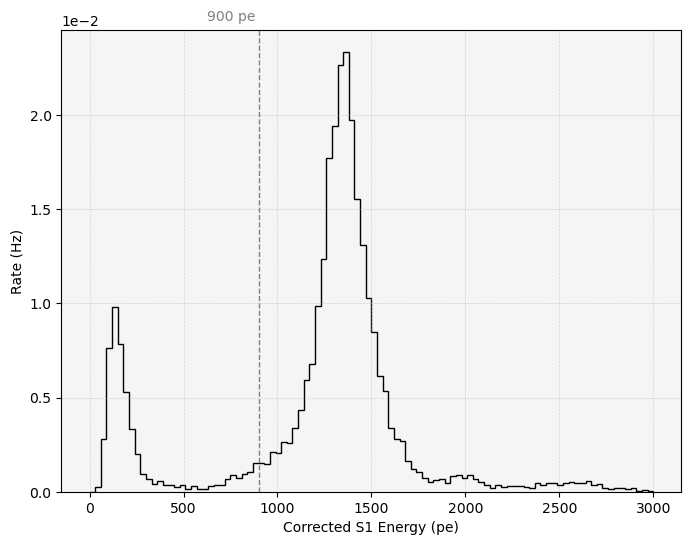

In [10]:
# Global
n_bins = 100
x_min, x_max = 0, 3e3
x_edges = np.linspace(x_min, x_max, n_bins + 1)

# S1 energy threshold
S1e_tresh = 900

plt.figure(figsize=(8, 6))

# ----- Run Loop ----- #
for i, run_id in enumerate(runs_info.keys()):

    # Run information
    run_long = runs_info[run_id]['duration']
    run_DAQe = runs_info[run_id]['OK'] / (runs_info[run_id]['OK'] + runs_info[run_id]['LOST'])

    # Data
    data = raw_data[run_id]['Dorothea']
    
    # Variables
    E1 = data['S1e_corr']

    # Histogram: normalized by corrected DAQ data taking time
    E1_counts, E1_edges = np.histogram(E1, bins=x_edges)
    E1_rate = E1_counts / (run_long * run_DAQe)

    # ----- Plotting ----- #
    plt.stairs(E1_rate, E1_edges, label=f'Run {run_id}', 
               fill=False, lw=1.0, ec=pt.hist_colors[i % len(pt.hist_colors)])
    
# S1 energy threshold
plt.axvline(x=S1e_tresh, color='gray', ls='--', lw=1)
plt.text(0.98*S1e_tresh, 2.5e-2, f'{S1e_tresh} pe', c='gray', ha='right')

# ----- Styling ----- #
plt.xlabel('Corrected S1 Energy (pe)')
plt.ylabel('Rate (Hz)')
# plt.yscale('log')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2, -2))
# plt.legend(loc='best', fontsize=9)

plt.grid(True, ls='--', lw=0.5, alpha=0.5)
plt.gca().set_facecolor("whitesmoke")
plt.show()

In [11]:
# Apply selection
for run_id in runs_info.keys():

    print(f"--- Processing Run {run_id} ---")
    
    # Event counters
    evts_sel   = 0
    evts_alpha = 0
    evts_elec  = 0

    # Dataframes
    data_dst  = raw_data[run_id]['Dorothea'];       evts_sel = data_dst.event.nunique()
    data_reco = raw_data[run_id]['Sophronia']

    # Event IDs for alphas and electrons
    alpha_ids = data_dst.loc[data_dst['S1e_corr'] >  S1e_tresh, 'event'].unique()
    elec_ids  = data_dst.loc[data_dst['S1e_corr'] <= S1e_tresh, 'event'].unique() 

    # ----- Storing Data ----- #
    sel_data[run_id]['Dorothea']['Alpha']['All'] = data_dst.loc[data_dst['event'].isin(alpha_ids)].copy()
    evts_alpha = sel_data[run_id]['Dorothea']['Alpha']['All'].event.nunique()
    print(f"\nAlphas candidates: {evts_alpha} events ({evts_alpha/evts_sel:.2%})")

    sel_data[run_id]['Dorothea']['Electron']['All'] = data_dst.loc[data_dst['event'].isin(elec_ids)].copy()
    evts_elec = sel_data[run_id]['Dorothea']['Electron']['All'].event.nunique()
    print(f"Electrons candidates: {evts_elec} events ({evts_elec/evts_sel:.2%})\n")

    sel_data[run_id]['Sophronia']['Alpha']['All']    = data_reco.loc[data_reco['event'].isin(alpha_ids)].copy()
    sel_data[run_id]['Sophronia']['Electron']['All'] = data_reco.loc[data_reco['event'].isin(elec_ids)].copy()

--- Processing Run 15557 ---

Alphas candidates: 11341 events (84.93%)
Electrons candidates: 2231 events (16.71%)



## Cleaning Isolated Hits

__Sophronia__
<br>
Clean up those damn spurious hits! Just use the function for $e$ population.
<br>
The cleaning for $\alpha$ population is made with just a cut on charge at the end of the processing.

In [12]:
# Cut on charge for alpha hits
Q_lim = 100         # in [pe]

# Setting up the filter of spurious hits
filter_config = {'distance': [15., 15.], 'nhit': 3, 'variables': ['E_corr']}
NO_hits_sp = crudo.drop_isolated_clusters_2D(**filter_config) 

# ----- Run Loop ----- #
for run_id in runs_info.keys():

    print(f"--- Processing Run {run_id} ---")

    # ----- Cleaning for Electrons ----- #
    for particle in ['Alpha', 'Electron']:

        # Event counters
        evts_prior = 0
        evts_post  = 0;

        # Data
        data = sel_data[run_id]['Sophronia'][particle]['All'];      evts_prior = data.event.nunique()
        print(f"\n→ {particle} ({evts_prior} events, {len(data)} hits)")

        if particle == 'Alpha':

            # Apply charge cut for alpha hits
            data = data[data['Q'] >= Q_lim].copy()
            hits_alpha_post = data.shape[0]
            print(f"Clean {particle}: {data.event.nunique()} events, {hits_alpha_post} hits ({data.event.nunique()/evts_prior:.2%})")

        elif particle == 'Electron':

            # Drop isolated clusters of hits (less than 4)
            data_evt = data.groupby('event')
            data = data_evt.apply(NO_hits_sp)
            data = data.reset_index(drop=True)

            # Efficiencies
            evts_post = data.event.nunique()
            hits_post = data.shape[0]
            print(f"Clean {particle}: {evts_post} events, {hits_post} hits ({evts_post/evts_prior:.2%})\n")

        # ----- Good Events ID ----- #
        good_evt = data['event'].unique()

        # ----- Store Data ----- #
        sel_data[run_id]['Dorothea'][particle]['All']  =  sel_data[run_id]['Dorothea'][particle]['All'][ sel_data[run_id]['Dorothea'][particle]['All']['event'].isin(good_evt)].copy()
        sel_data[run_id]['Sophronia'][particle]['All'] = data.copy()

--- Processing Run 15557 ---

→ Alpha (11341 events, 27273745 hits)
Clean Alpha: 11340 events, 1399821 hits (99.99%)

→ Electron (2231 events, 1251854 hits)
Clean Electron: 2231 events, 1113634 hits (100.00%)



## Data @ Event-level 

Here, a new __event-level__ (different to _Dorothea_) representation of the data is generated. The $XYZ$ position for each event is computed as the energy-weighted sum of constituent hits, defined as:

$X_\text{event} = \frac{\sum E_{\text{hit}}\cdot X_{\text{hit}}}{\sum E_{\text{hit}}}$

In [13]:
# ----- Run Loop ----- #
for run_id in runs_info.keys():

    print(f"--- Processing Run {run_id} ---")

    # ----- Processing for Alphas and Electrons ----- #
    for particle in ['Alpha', 'Electron']:  

        # Data
        data = sel_data[run_id]['Sophronia'][particle]['All']

        # Group sophronia data by event
        reco_evt  = data.groupby('event')
        events_df = []

        for i, event in enumerate(reco_evt):

            # Event info
            event_id   = event[0]
            event_data = event[1]

            # Variables
            T = event_data['time']
            X = event_data['X']
            Y = event_data['Y']
            Z = event_data['Z_real']
            E = event_data['E_corr']

            # Compute event-level weighted averages and sums
            T_evt = np.mean(T)             # Mean time
            E_evt = np.sum(E)              # Total energy
            X_evt = np.sum(E * X) / E_evt  # Energy-weighted X
            Y_evt = np.sum(E * Y) / E_evt  # Energy-weighted Y
            Z_evt = np.sum(E * Z) / E_evt  # Energy-weighted Z

            # Create a dataframe for the event-level information
            df = pd.DataFrame({'event': [event_id], 'time': [T_evt], 'X': [X_evt], 'Y': [Y_evt], 'Z': [Z_evt], 'E_corr': [E_evt]})
            events_df.append(df)

        # Combine event-level dataframes for the run
        sel_data[run_id]['Event'][particle]['All'] = pd.concat(events_df, ignore_index=True)

--- Processing Run 15557 ---


#### Efficiency of the trigger 02.

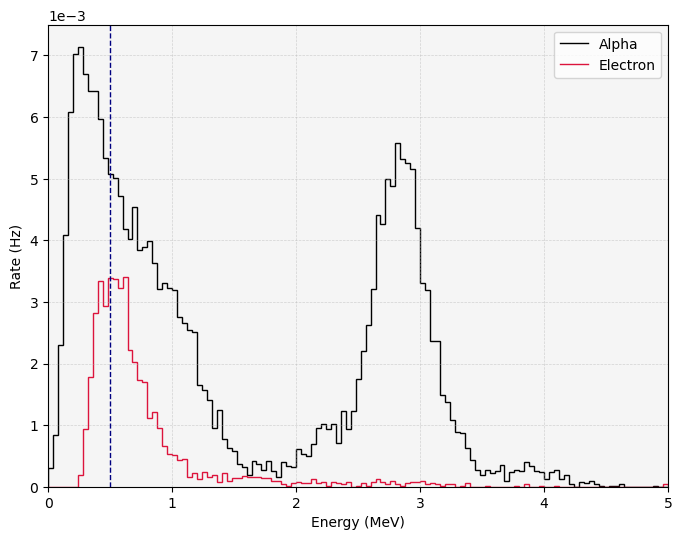

In [14]:
# Global
n_bins = 250
x_min, x_max = 0, 10
x_edges = np.linspace(x_min, x_max, n_bins + 1)

# Energy threshold
E_trigger = 0.5

# ----- Run Loop ----- #
for run_id in runs_info.keys():

    # Run information
    run_long = runs_info[run_id]['duration']
    run_DAQe = runs_info[run_id]['OK'] / (runs_info[run_id]['OK'] + runs_info[run_id]['LOST'])

    plt.figure(figsize=(8, 6))

    # ----- Plotting for Alphas and Electrons ----- #
    for j, particle in enumerate(['Alpha', 'Electron']):

        # Data
        data = sel_data[run_id]['Event'][particle]['All']
    
        # Variables
        E = data['E_corr']

        # Histogram: normalized by corrected DAQ data taking time
        E_counts, E_edges = np.histogram(E, bins=x_edges)
        E_rate = E_counts / (run_long * run_DAQe)

        # ----- Plotting ----- #
        plt.stairs(E_rate, E_edges, label=f'{particle}', 
                   fill=False, lw=1.0, ec=pt.hist_colors[j % len(pt.hist_colors)])
    

    # Energy threshold due to trigger 2 efficiency
    plt.axvline(x=E_trigger, color='navy', ls='--', lw=1)

    # Styling
    plt.xlabel('Energy (MeV)')
    plt.xlim(0, 5)
    plt.ylabel('Rate (Hz)')
    # plt.yscale('log')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))
    plt.legend(fontsize=10, loc='best')
    # plt.title(f'Event-level: Run {run_id}')

    plt.grid(True, ls='--', lw=0.5, alpha=0.5)
    plt.gca().set_facecolor("whitesmoke")
    plt.show()

In [31]:
# Apply selection
for run_id in runs_info.keys():

    print(f"\n--- Processing Run {run_id} ---\n")

    # ----- Processing for Alphas and Electrons ----- #
    for particle in ['Alpha', 'Electron']:

        # Event counters
        evts_prior = 0
        evts_post  = 0

        # Data
        data_dor  = sel_data[run_id]['Dorothea'][particle]['All'];     
        data_reco = sel_data[run_id]['Sophronia'][particle]['All'];     evts_prior = data_reco.event.nunique()
        data_evt  = sel_data[run_id]['Event'][particle]['All']

        # Event IDs for alphas and electrons
        evt_ids = data_evt.loc[data_evt['E_corr'] >= E_trigger, 'event'].unique()

        # ----- Storing Data ----- #
        sel_data[run_id]['Dorothea'][particle]['All'] = data_dor.loc[data_dor['event'].isin(evt_ids)].copy()

        sel_data[run_id]['Sophronia'][particle]['All'] = data_reco.loc[data_reco['event'].isin(evt_ids)]
        evts_post = sel_data[run_id]['Sophronia'][particle]['All'].event.nunique()
        print(f"{particle}: {evts_post} events ({evts_post/evts_prior:.2%})")

        sel_data[run_id]['Event'][particle]['All'] = data_evt.loc[data_evt['event'].isin(evt_ids)]


--- Processing Run 15557 ---

Alpha: 8245 events (72.71%)
Electron: 1529 events (68.53%)


# Selection

## $nS2 = 1$

In [15]:
# Apply selection
for run_id in runs_info.keys():

    print(f"\n--- Processing Run {run_id} ---\n")

    # ----- Processing for Alphas and Electrons ----- #
    for particle in ['Alpha', 'Electron']:

        # Event counters
        evts_prior = 0
        evts_post  = 0

        # Data
        data_dor  = sel_data[run_id]['Dorothea'][particle]['All'];      evts_prior = data_dor.event.nunique()       
        data_reco = sel_data[run_id]['Sophronia'][particle]['All'];     
        data_evt  = sel_data[run_id]['Event'][particle]['All']

        # Just one S2
        data_dor = data_dor[data_dor['nS2'] == 1].copy()

        # Event IDs
        evt_ids = data_dor['event'].unique()

        # ----- Storing Data ----- #
        sel_data[run_id]['Dorothea'][particle]['All'] = data_dor.copy()
        evts_post = sel_data[run_id]['Dorothea'][particle]['All'].event.nunique()
        print(f"{particle}: {evts_post} events ({evts_post/evts_prior:.2%})")

        sel_data[run_id]['Sophronia'][particle]['All'] = data_reco.loc[data_reco['event'].isin(evt_ids)]

        sel_data[run_id]['Event'][particle]['All'] = data_evt.loc[data_evt['event'].isin(evt_ids)]


--- Processing Run 15557 ---

Alpha: 10106 events (89.12%)
Electron: 1737 events (77.86%)


## Detector Regions

In [16]:
# Containment limits definition 
Z_low = 40          # in [mm]
Z_up  = 1147        # in [mm]
R_up  = 451.65      # in [mm]

In [17]:
# ----- Run Loop ----- #
for run_id in runs_info.keys():

    print(f"\n--- Processing Run {run_id} ---")

    # ----- Processing for Alphas and Electrons ----- #
    for particle in ['Alpha', 'Electron']:

        print(f"\n→ {particle}:")

        # Event counter
        evts_prior = 0

        # Data
        data_reco = sel_data[run_id]['Sophronia'][particle]['All'];     evts_prior = data_reco.event.nunique()
        data_evt  = sel_data[run_id]['Event'][particle]['All']

        # Group sophronia data by event
        soph_evt = data_reco.groupby('event')

        # Event IDs containers for each detector region
        fiducial_ids = []
        tube_ids     = []
        anode_ids    = []
        cathode_ids  = []

        for i, evt in enumerate(soph_evt):
            
            # Event info
            event_id   = evt[0]
            event_data = evt[1]

            # Variables
            R_hits = np.sqrt(event_data['X']**2 + event_data['Y']**2)
            Z_hits = event_data['Z_real']

            # Maximum and minimum Z and R values
            min_Z = Z_hits.min();  max_Z = Z_hits.max()
            min_R = R_hits.min();  max_R = R_hits.max()            

            # Apply limits by detector region
            if   (min_Z >= Z_low) and (max_Z <= Z_up) and (max_R <= R_up):    fiducial_ids.append(event_id)
            elif (min_Z >= Z_low) and (max_Z <= Z_up) and (max_R >  R_up):    tube_ids.append(event_id)
            elif (min_Z <  Z_low):                                            anode_ids.append(event_id)
            elif (max_Z >  Z_up):                                             cathode_ids.append(event_id)

        # ----- Storing Data ----- #
        sel_data[run_id]['Sophronia'][particle]['Fiducial'] = data_reco.loc[data_reco['event'].isin(fiducial_ids)].copy()
        print(f"Fiducial: {len(fiducial_ids)} events ({len(fiducial_ids)/evts_prior:.2%})")

        sel_data[run_id]['Sophronia'][particle]['Tube']     = data_reco.loc[data_reco['event'].isin(tube_ids)].copy()
        print(f"Tube:     {len(tube_ids)} events ({len(tube_ids)/evts_prior:.2%})")

        sel_data[run_id]['Sophronia'][particle]['Anode']    = data_reco.loc[data_reco['event'].isin(anode_ids)].copy()
        print(f"Anode:    {len(anode_ids)} events ({len(anode_ids)/evts_prior:.2%})")
        
        sel_data[run_id]['Sophronia'][particle]['Cathode']  = data_reco.loc[data_reco['event'].isin(cathode_ids)].copy()
        print(f"Cathode:  {len(cathode_ids)} events ({len(cathode_ids)/evts_prior:.2%})")
        
        sel_data[run_id]['Event'][particle]['Fiducial'] = data_evt.loc[data_evt['event'].isin(fiducial_ids)].copy()
        sel_data[run_id]['Event'][particle]['Tube']     = data_evt.loc[data_evt['event'].isin(tube_ids)].copy()
        sel_data[run_id]['Event'][particle]['Anode']    = data_evt.loc[data_evt['event'].isin(anode_ids)].copy()
        sel_data[run_id]['Event'][particle]['Cathode']  = data_evt.loc[data_evt['event'].isin(cathode_ids)].copy()


--- Processing Run 15557 ---

→ Alpha:
Fiducial: 1022 events (10.11%)
Tube:     6302 events (62.36%)
Anode:    158 events (1.56%)
Cathode:  2624 events (25.96%)

→ Electron:
Fiducial: 434 events (24.99%)
Tube:     528 events (30.40%)
Anode:    45 events (2.59%)
Cathode:  730 events (42.03%)


# Output

#### Configuration

In [18]:
# ----- DataFrames ----- #
output_dir = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/data/solo/'
print(f"Output directory: {output_dir}")

# ----- .txt with Run extra info ----- #
output_txt = "runs_extra_info.txt"
txt_path = os.path.join("./NEXT-100/Backgrounds/txt/", output_txt)
print(f"Output text file: {txt_path}")

Output directory: /lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/data/solo/
Output text file: ./NEXT-100/Backgrounds/txt/runs_extra_info.txt


In [19]:
with open(txt_path, 'a') as info:

    # info.write("Run ID\tDate_CV\tDate_err\tReco_evts\n")

    # ----- Run Loop ----- #
    for run_id, data in sel_data.items():

        # # ----- Store Extra Infor ----- #
        # # Raw data
        # raw_dst = raw_data[run_id]['Dorothea']

        # # Run date
        # Date_CV  = raw_dst.time.mean()
        # Date_err = raw_dst.time.std() / np.sqrt(len(raw_dst.time))

        # # Reco events
        # Reco_CV = runs_info[run_id]['Reco_CV']

        # # Write to file
        # info.write(f"{run_id}\t{Date_CV:.4f}\t{Date_err:.4f}\t{Reco_CV}\n")
        # # print(f"Run {run_id}: Date_CV = {Date_CV:.4f}, Date_err = {Date_err:.4f}, Reco_CV = {Reco_CV}")

        # ----- Save DataFrames to HDF5 ----- #
        # Output filename
        h5_name = f'run_{run_id}_sel_data.h5'
        h5_path = os.path.join(output_dir, h5_name)

        print(f"\n--- Run {run_id}: Saving data to {os.path.basename(h5_path)} ---")

        crudo.save_dataframes(data, h5_path)


--- Run 15535: Saving data to run_15535_sel_data.h5 ---
    Saved DataFrame to key: 'Dorothea/Alpha/All' (9910, 27)
    Saved DataFrame to key: 'Dorothea/Electron/All' (1571, 27)
    Saved DataFrame to key: 'Sophronia/Alpha/All' (1546020, 20)
    Saved DataFrame to key: 'Sophronia/Alpha/Fiducial' (283386, 20)
    Saved DataFrame to key: 'Sophronia/Alpha/Tube' (389818, 20)
    Saved DataFrame to key: 'Sophronia/Alpha/Anode' (7307, 20)
    Saved DataFrame to key: 'Sophronia/Alpha/Cathode' (865509, 20)
    Saved DataFrame to key: 'Sophronia/Electron/All' (900916, 20)
    Saved DataFrame to key: 'Sophronia/Electron/Fiducial' (162151, 20)
    Saved DataFrame to key: 'Sophronia/Electron/Tube' (305524, 20)
    Saved DataFrame to key: 'Sophronia/Electron/Anode' (13602, 20)
    Saved DataFrame to key: 'Sophronia/Electron/Cathode' (419639, 20)
    Saved DataFrame to key: 'Event/Alpha/All' (9910, 6)
    Saved DataFrame to key: 'Event/Alpha/Fiducial' (1304, 6)
    Saved DataFrame to key: 'Event/A